# Portfolio Risk Management Analysis
## Q3 in HW4 and HW5

In [12]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from arch import arch_model


In [13]:
# Load the data
df = pd.read_csv('NAV.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df = df.set_index('Date')
df['returns'] = df['NAV'].pct_change() * 100
df = df.dropna()

print(f"Data loaded: {len(df)} observations")
print(f"Period: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")
df.head()


Data loaded: 4025 observations
Period: 2001-01-02 to 2016-12-30


,NAV,returns
Date,,
2001-01-02,97.20,-2.800000
2001-01-03,102.25,5.195473
2001-01-04,101.16,-1.066015
2001-01-05,98.51,-2.619612
2001-01-08,98.34,-0.172571


## Part (a): Monthly Realized Volatility
Compute the monthly realized volatility for the portfolio. Plot the realized volatility series, and comment on its properties.

In [14]:
# Resample returns to monthly frequency and compute realized volatility
# Realized volatility = standard deviation of daily returns within each month
monthly_realized_vol = df['returns'].resample('M').std()

print("Monthly Realized Volatility Statistics:")
print("="*60)
print(f"Mean:   {monthly_realized_vol.mean():.4f}%")
print(f"Median: {monthly_realized_vol.median():.4f}%")
print(f"Std:    {monthly_realized_vol.std():.4f}%")
print(f"Min:    {monthly_realized_vol.min():.4f}%")
print(f"Max:    {monthly_realized_vol.max():.4f}%")
print("="*60)

monthly_realized_vol.head(10)

Monthly Realized Volatility Statistics:
Mean:   1.0490%
Median: 0.8841%
Std:    0.6665%
Min:    0.2574%
Max:    5.1426%


/var/folders/cf/zk37hd_50bv_nlrdlxrb4q3r0000gn/T/ipykernel_69171/2499213484.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_realized_vol = df['returns'].resample('M').std()


Date
2001-01-31    1.592291
2001-02-28    1.070559
2001-03-31    1.813884
2001-04-30    1.964251
2001-05-31    1.106862
2001-06-30    0.862483
2001-07-31    1.198696
2001-08-31    0.958280
2001-09-30    2.168882
2001-10-31    1.211716
Freq: ME, Name: returns, dtype: float64

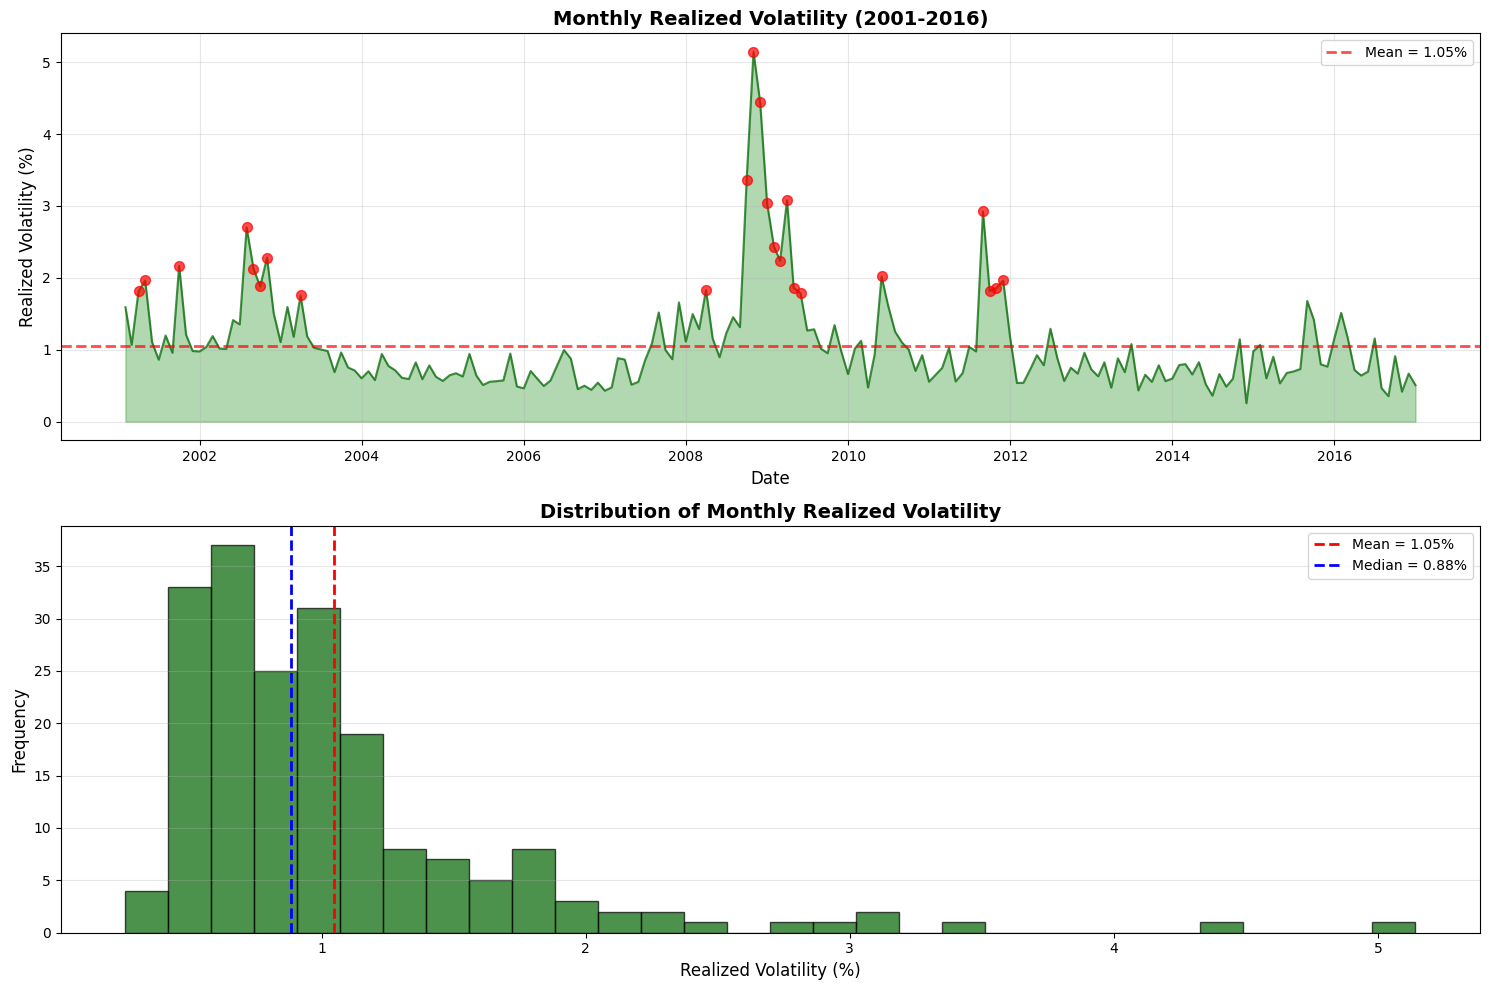


PROPERTIES OF REALIZED VOLATILITY:
• Time-varying: Volatility changes significantly over time
• Clustering: High volatility periods tend to cluster together
• Mean reversion: Volatility tends to revert to its long-run average
• Skewed distribution: 2.77 skewness
• Fat tails: 11.08 excess kurtosis
• Notable spikes during crisis periods (e.g., 2008 financial crisis)


In [15]:
# Plot the monthly realized volatility
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Time series plot
axes[0].plot(monthly_realized_vol.index, monthly_realized_vol, linewidth=1.5, color='darkgreen', alpha=0.7)
axes[0].axhline(y=monthly_realized_vol.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean = {monthly_realized_vol.mean():.2f}%', alpha=0.7)
axes[0].fill_between(monthly_realized_vol.index, monthly_realized_vol, alpha=0.3, color='green')
axes[0].set_title('Monthly Realized Volatility (2001-2016)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Realized Volatility (%)', fontsize=12)
axes[0].set_xlabel('Date', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='upper right')

# Highlight high volatility periods
high_vol_threshold = monthly_realized_vol.mean() + monthly_realized_vol.std()
high_vol_mask = monthly_realized_vol > high_vol_threshold
axes[0].scatter(monthly_realized_vol[high_vol_mask].index, 
                monthly_realized_vol[high_vol_mask], 
                color='red', s=50, zorder=5, label='High volatility periods', alpha=0.7)

# Histogram
axes[1].hist(monthly_realized_vol, bins=30, color='darkgreen', alpha=0.7, edgecolor='black')
axes[1].axvline(x=monthly_realized_vol.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean = {monthly_realized_vol.mean():.2f}%')
axes[1].axvline(x=monthly_realized_vol.median(), color='blue', linestyle='--', linewidth=2,
                label=f'Median = {monthly_realized_vol.median():.2f}%')
axes[1].set_title('Distribution of Monthly Realized Volatility', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Realized Volatility (%)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("PROPERTIES OF REALIZED VOLATILITY:")
print("="*80)
print("• Time-varying: Volatility changes significantly over time")
print("• Clustering: High volatility periods tend to cluster together")
print("• Mean reversion: Volatility tends to revert to its long-run average")
print(f"• Skewed distribution: {monthly_realized_vol.skew():.2f} skewness")
print(f"• Fat tails: {monthly_realized_vol.kurtosis():.2f} excess kurtosis")
print("• Notable spikes during crisis periods (e.g., 2008 financial crisis)")
print("="*80)

## Part (b): Value at Risk (VaR) Analysis
Based on the estimated AR(1)-GARCH(1,1) model for Q3 in HW4, compute the 1-day and 10-day 1% VaR of your portfolio every day from 2002 to 2016. Plot the two time series.

In [16]:
# Fit AR(1)-GARCH(1,1) model
model = arch_model(df['returns'], mean='AR', lags=1, vol='GARCH', p=1, q=1)
results = model.fit(disp='off')

print("="*80)
print(" " * 20 + "AR(1)-GARCH(1,1) MODEL RESULTS")
print("="*80)
print(results.summary())


                    AR(1)-GARCH(1,1) MODEL RESULTS
                           AR - GARCH Model Results                           
Dep. Variable:                returns   R-squared:                       0.006
Mean Model:                        AR   Adj. R-squared:                  0.006
Vol Model:                      GARCH   Log-Likelihood:               -5578.54
Distribution:                  Normal   AIC:                           11167.1
Method:            Maximum Likelihood   BIC:                           11198.6
                                        No. Observations:                 4024
Date:                Wed, Nov 12 2025   Df Residuals:                     4022
Time:                        18:05:16   Df Model:                            2
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
C

In [17]:
# Filter data from 2002 to 2016
df_var = df.loc['2002':'2016'].copy()

# Get conditional volatility from the fitted model
conditional_volatility = results.conditional_volatility

# Calculate the conditional mean for AR(1) model
# For AR(1): E[r_t | I_{t-1}] = const + phi * r_{t-1}
const = results.params['Const']
phi = results.params['returns[1]']

# Calculate conditional mean using AR(1) formula
conditional_mean = pd.Series(index=df.index, dtype=float)
conditional_mean.iloc[0] = const  # First observation uses unconditional mean
for i in range(1, len(df)):
    conditional_mean.iloc[i] = const + phi * df['returns'].iloc[i-1]

# Align with our filtered dataframe
conditional_volatility_filtered = conditional_volatility.loc['2002':'2016']
conditional_mean_filtered = conditional_mean.loc['2002':'2016']

# Calculate 1-day VaR at 1% confidence level
# VaR_1% = mean + z_0.01 * sigma
# For 1% VaR (lower tail), z_0.01 = -2.326 (1st percentile of standard normal)
from scipy.stats import norm
z_001 = norm.ppf(0.01)  # -2.326

# 1-day VaR (negative values indicate losses)
var_1day = conditional_mean_filtered + z_001 * conditional_volatility_filtered

# 10-day VaR calculation using square-root-of-time rule
# Assumes returns are i.i.d. - simplified approach
var_10day = conditional_mean_filtered * 10 + z_001 * conditional_volatility_filtered * np.sqrt(10)

print(f"Period: {df_var.index[0].strftime('%Y-%m-%d')} to {df_var.index[-1].strftime('%Y-%m-%d')}")
print(f"Number of observations: {len(var_1day)}")
print(f"\n1-Day VaR Statistics:")
print(f"  Mean: {var_1day.mean():.4f}%")
print(f"  Std:  {var_1day.std():.4f}%")
print(f"  Min:  {var_1day.min():.4f}%")
print(f"  Max:  {var_1day.max():.4f}%")
print(f"\n10-Day VaR Statistics:")
print(f"  Mean: {var_10day.mean():.4f}%")
print(f"  Std:  {var_10day.std():.4f}%")
print(f"  Min:  {var_10day.min():.4f}%")
print(f"  Max:  {var_10day.max():.4f}%")


Period: 2002-01-02 to 2016-12-30
Number of observations: 3777

1-Day VaR Statistics:
  Mean: -2.3702%
  Std:  1.3498%
  Min:  -12.9311%
  Max:  -1.0880%

10-Day VaR Statistics:
  Mean: -7.0395%
  Std:  4.3313%
  Min:  -45.5466%
  Max:  -2.8730%


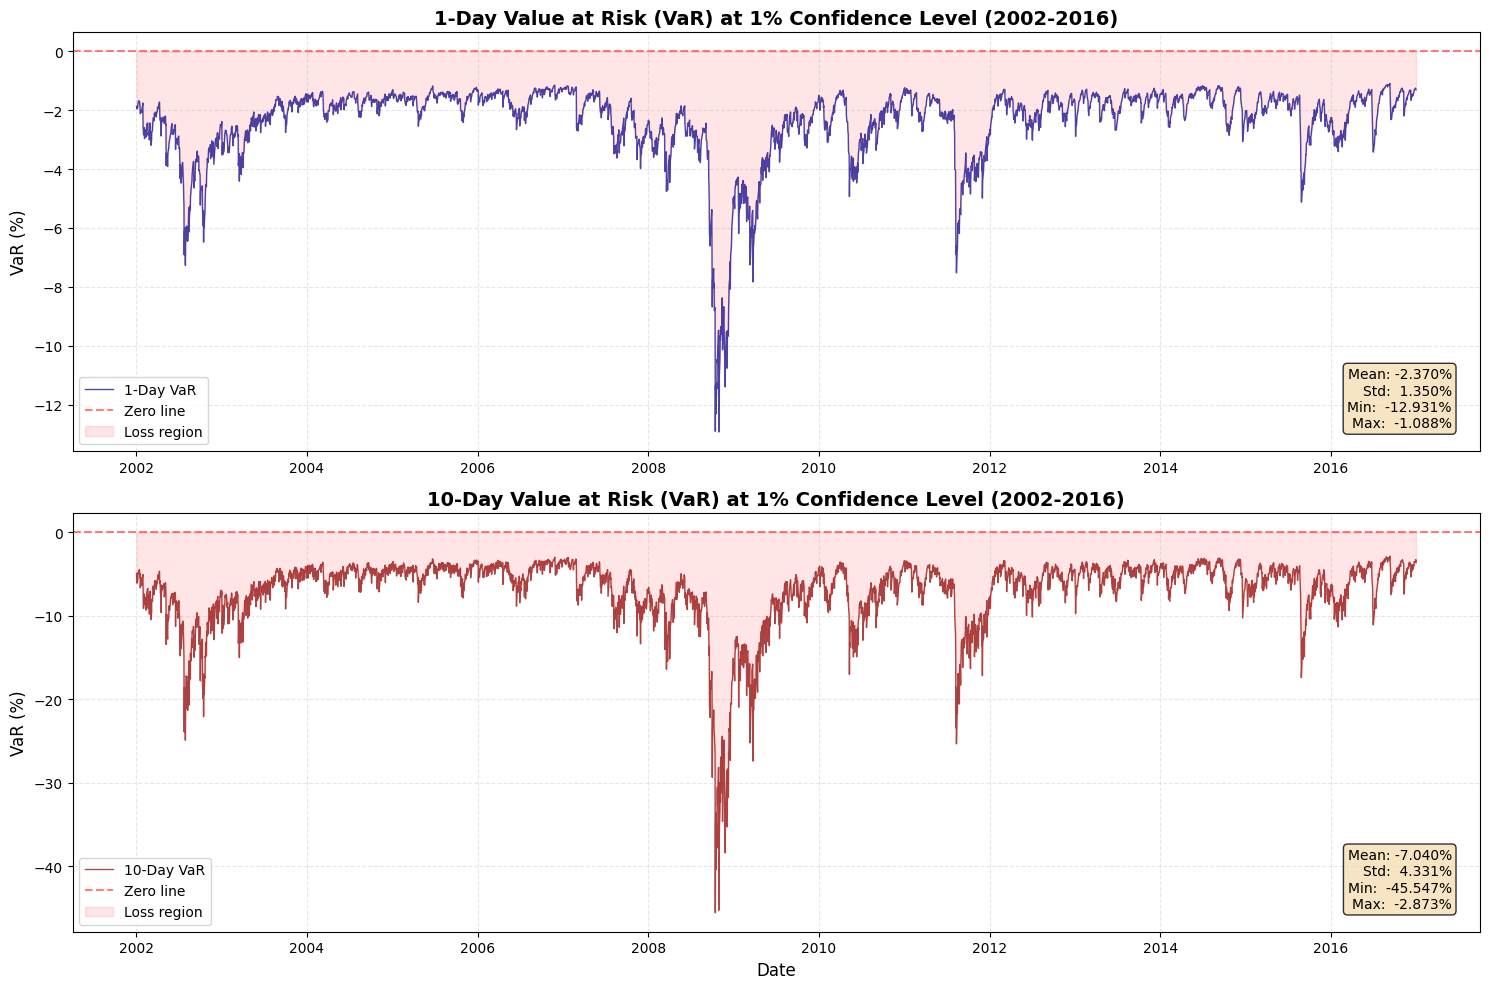


INTERPRETATION:
• Negative VaR values indicate potential losses
• 1% VaR means there is a 1% probability that losses will exceed this value
• Periods with more negative VaR indicate higher risk (e.g., 2008 financial crisis)
• 10-day VaR is approximately √10 ≈ 3.16 times larger than 1-day VaR
• Red shaded regions show when VaR predicts potential losses


In [18]:
# Plot both VaR time series
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1-day VaR
axes[0].plot(var_1day.index, var_1day, linewidth=1, color='darkblue', alpha=0.7, label='1-Day VaR')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Zero line')
axes[0].fill_between(var_1day.index, var_1day, 0, where=(var_1day < 0), 
                       color='red', alpha=0.1, label='Loss region')
axes[0].set_title('1-Day Value at Risk (VaR) at 1% Confidence Level (2002-2016)', 
                   fontsize=14, fontweight='bold')
axes[0].set_ylabel('VaR (%)', fontsize=12)
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].legend(loc='lower left')

# Add statistics text box
stats_text_1day = (f'Mean: {var_1day.mean():.3f}%\n'
                   f'Std:  {var_1day.std():.3f}%\n'
                   f'Min:  {var_1day.min():.3f}%\n'
                   f'Max:  {var_1day.max():.3f}%')
axes[0].text(0.98, 0.05, stats_text_1day, transform=axes[0].transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             fontsize=10, verticalalignment='bottom', horizontalalignment='right')

# Plot 10-day VaR
axes[1].plot(var_10day.index, var_10day, linewidth=1, color='darkred', alpha=0.7, label='10-Day VaR')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Zero line')
axes[1].fill_between(var_10day.index, var_10day, 0, where=(var_10day < 0), 
                       color='red', alpha=0.1, label='Loss region')
axes[1].set_title('10-Day Value at Risk (VaR) at 1% Confidence Level (2002-2016)', 
                   fontsize=14, fontweight='bold')
axes[1].set_ylabel('VaR (%)', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].legend(loc='lower left')

# Add statistics text box
stats_text_10day = (f'Mean: {var_10day.mean():.3f}%\n'
                    f'Std:  {var_10day.std():.3f}%\n'
                    f'Min:  {var_10day.min():.3f}%\n'
                    f'Max:  {var_10day.max():.3f}%')
axes[1].text(0.98, 0.05, stats_text_10day, transform=axes[1].transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             fontsize=10, verticalalignment='bottom', horizontalalignment='right')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)
print("• Negative VaR values indicate potential losses")
print("• 1% VaR means there is a 1% probability that losses will exceed this value")
print("• Periods with more negative VaR indicate higher risk (e.g., 2008 financial crisis)")
print("• 10-day VaR is approximately √10 ≈ 3.16 times larger than 1-day VaR")
print("• Red shaded regions show when VaR predicts potential losses")
print("="*80)


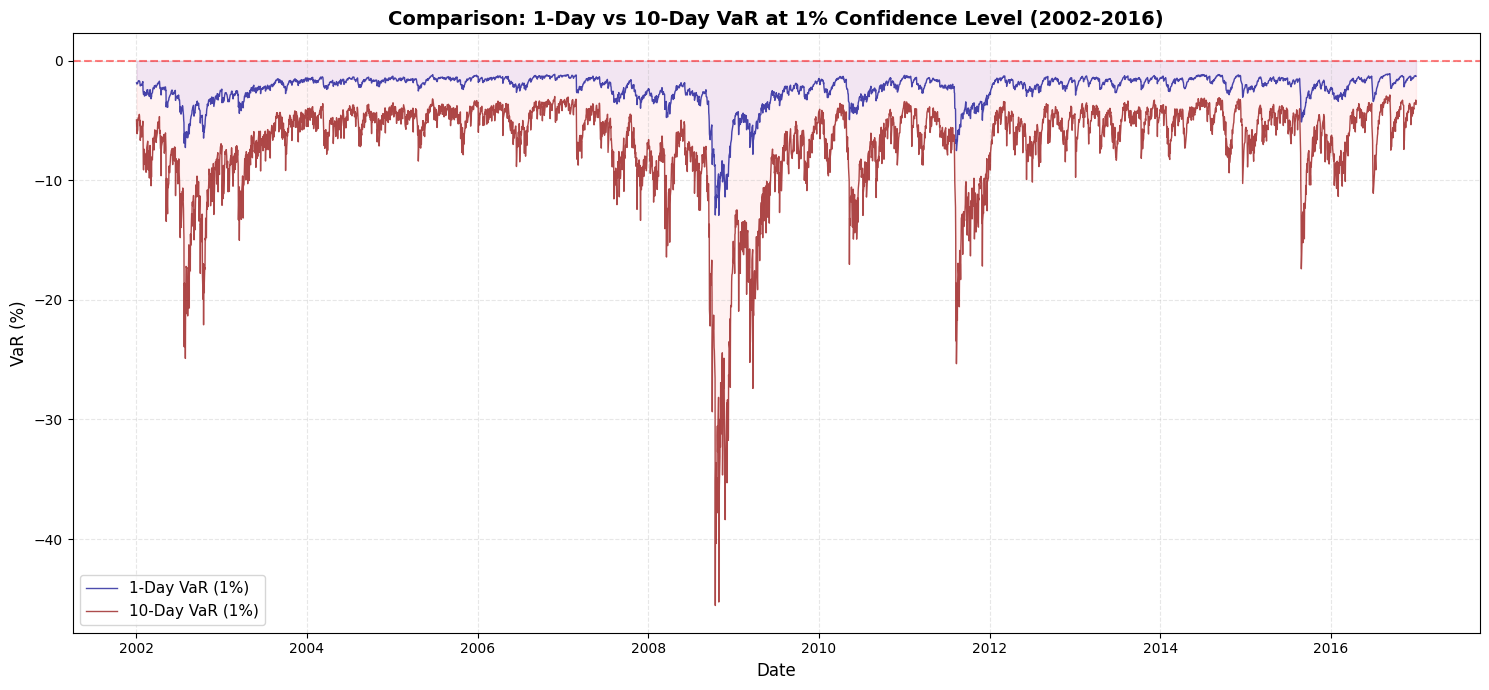

In [19]:
# Optional: Plot both VaR series on the same plot for comparison
plt.figure(figsize=(15, 7))
plt.plot(var_1day.index, var_1day, linewidth=1, color='darkblue', alpha=0.7, label='1-Day VaR (1%)')
plt.plot(var_10day.index, var_10day, linewidth=1, color='darkred', alpha=0.7, label='10-Day VaR (1%)')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
plt.fill_between(var_1day.index, var_1day, 0, where=(var_1day < 0), color='blue', alpha=0.05)
plt.fill_between(var_10day.index, var_10day, 0, where=(var_10day < 0), color='red', alpha=0.05)
plt.title('Comparison: 1-Day vs 10-Day VaR at 1% Confidence Level (2002-2016)', 
          fontsize=14, fontweight='bold')
plt.ylabel('VaR (%)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(loc='lower left', fontsize=11)
plt.tight_layout()
plt.show()

## Part (c): Constant Proportion Portfolio Insurance (CPPI) Strategy
Notice that your NAV dropped below $70 multiple times. Suppose your investor demanded from the start that the portfolio be liquidated whenever its NAV falls below $90. Without changing the portfolio composition (so that the return on equity investment remains the same) but instead simply by adjusting the fraction in equity and in cash each period, could you have avoided liquidation? What would your NAV have been at the end of 2016 based on this strategy? Assume that the annualized risk-free rate on cash holding is 1%.

NAV Analysis:
Starting NAV: $97.20
Ending NAV: $317.46
Min NAV: $63.46
Max NAV: $321.91

Times NAV dropped below $70: 51
Times NAV dropped below $90: 598


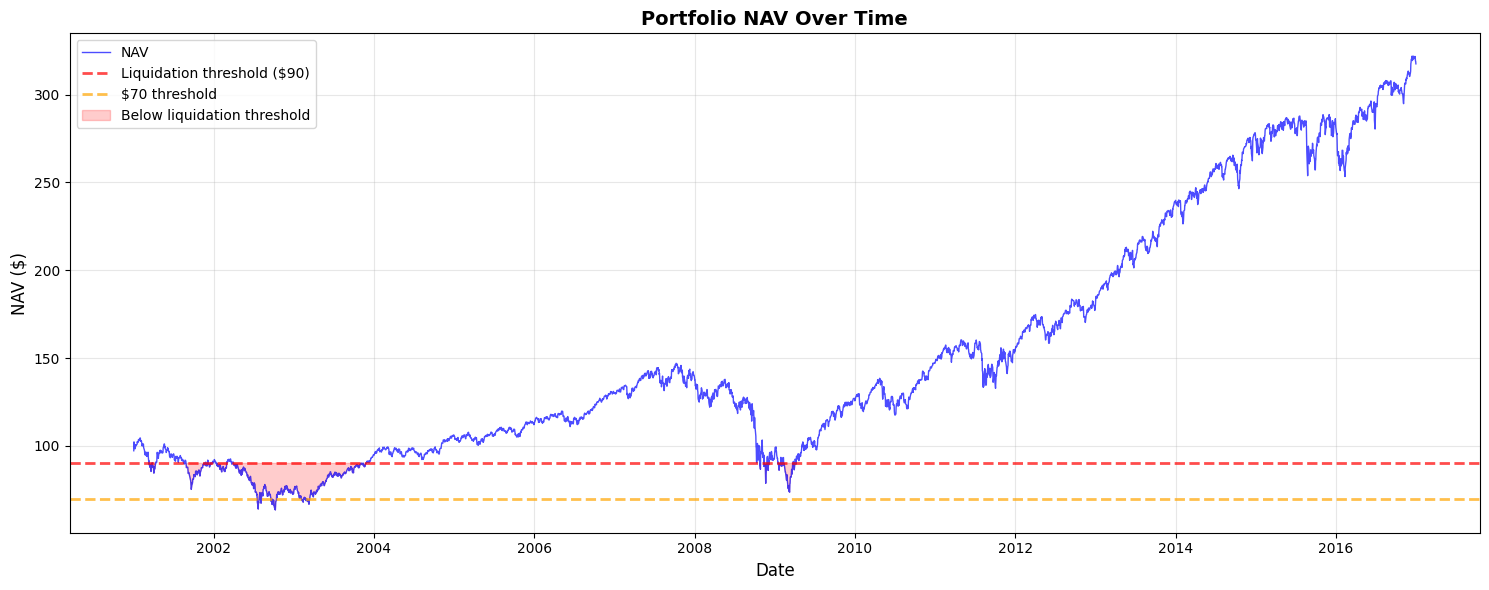

In [20]:
# First, let's see how many times NAV dropped below $70 and analyze the data
print("NAV Analysis:")
print("="*60)
print(f"Starting NAV: ${df['NAV'].iloc[0]:.2f}")
print(f"Ending NAV: ${df['NAV'].iloc[-1]:.2f}")
print(f"Min NAV: ${df['NAV'].min():.2f}")
print(f"Max NAV: ${df['NAV'].max():.2f}")
print(f"\nTimes NAV dropped below $70: {(df['NAV'] < 70).sum()}")
print(f"Times NAV dropped below $90: {(df['NAV'] < 90).sum()}")
print("="*60)

# Plot NAV with thresholds
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['NAV'], linewidth=1, color='blue', alpha=0.7, label='NAV')
plt.axhline(y=90, color='red', linestyle='--', linewidth=2, label='Liquidation threshold ($90)', alpha=0.7)
plt.axhline(y=70, color='orange', linestyle='--', linewidth=2, label='$70 threshold', alpha=0.7)
plt.fill_between(df.index, df['NAV'], 90, where=(df['NAV'] < 90), 
                  color='red', alpha=0.2, label='Below liquidation threshold')
plt.title('Portfolio NAV Over Time', fontsize=14, fontweight='bold')
plt.ylabel('NAV ($)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# CPPI Strategy Implementation - Version 2
# We'll use a more conservative approach with a safety buffer

from scipy.stats import norm

# Get model parameters
const = results.params['Const']
phi = results.params['returns[1]']
omega = results.params['omega']
alpha = results.params['alpha[1]']
beta = results.params['beta[1]']

# Calculate unconditional volatility for backup
unconditional_vol = np.sqrt(omega / (1 - alpha - beta))

# Parameters
floor = 90  # Liquidation threshold
safety_buffer = 0.5  # Extra cushion above floor ($0.50)
effective_floor = floor + safety_buffer
initial_nav = df['NAV'].iloc[0]
risk_free_rate_annual = 0.01
risk_free_rate_daily = (1 + risk_free_rate_annual)**(1/252) - 1
confidence_level = 0.01  # 1% tail probability
z_001 = norm.ppf(confidence_level)  # -2.326

print("="*80)
print("CPPI STRATEGY - IMPROVED IMPLEMENTATION")
print("="*80)
print(f"Floor: ${floor:.2f}")
print(f"Effective floor (with safety buffer): ${effective_floor:.2f}")
print(f"Initial NAV: ${initial_nav:.2f}")
print(f"Risk-free rate (daily): {risk_free_rate_daily*100:.4f}%")
print(f"VaR z-score (1%): {z_001:.3f}")
print(f"Unconditional volatility: {unconditional_vol:.4f}%")
print("="*80)

# Initialize arrays
cppi_nav = np.zeros(len(df))
equity_weight = np.zeros(len(df))
equity_value = np.zeros(len(df))
cash_value = np.zeros(len(df))

# Day 0: Start conservatively
cppi_nav[0] = initial_nav
cushion_0 = initial_nav - effective_floor

# Use unconditional volatility for day 0 (or day 1's conditional vol if available)
if len(results.conditional_volatility) > 1:
    sigma_0 = results.conditional_volatility.iloc[1]  # Use next day's forecast
else:
    sigma_0 = unconditional_vol

# Calculate conditional mean for day 1
mu_0 = const  # First forecast uses just constant

# Calculate max equity exposure
# We want: P(NAV_tomorrow < floor) < 1%
# NAV_tomorrow = NAV_0 + equity_value * r_tomorrow + cash_value * rf
# r_tomorrow ~ N(mu, sigma^2)
# Worst case: NAV_0 + equity_value * (mu + z_0.01 * sigma) / 100 >= floor
# Since z_0.01 is negative and dominates:
# equity_value <= (NAV_0 - floor) / ((-z_0.01 * sigma) / 100)

max_equity_value_0 = cushion_0 / ((-z_001) * sigma_0 / 100)
equity_weight[0] = min(max_equity_value_0 / initial_nav, 1.0)
equity_value[0] = initial_nav * equity_weight[0]
cash_value[0] = initial_nav * (1 - equity_weight[0])

print(f"\nDay 0 Initialization:")
print(f"  Cushion: ${cushion_0:.2f}")
print(f"  Sigma forecast: {sigma_0:.4f}%")
print(f"  Max equity value: ${max_equity_value_0:.2f}")
print(f"  Equity weight: {equity_weight[0]*100:.2f}%")
print(f"  Equity value: ${equity_value[0]:.2f}")
print(f"  Cash value: ${cash_value[0]:.2f}")

# Simulate day by day
for i in range(1, len(df)):
    # Get today's equity return
    equity_return_pct = df['returns'].iloc[i]
    
    # Update portfolio values
    equity_value[i] = equity_value[i-1] * (1 + equity_return_pct / 100)
    cash_value[i] = cash_value[i-1] * (1 + risk_free_rate_daily)
    cppi_nav[i] = equity_value[i] + cash_value[i]
    
    # Calculate cushion
    cushion = cppi_nav[i] - effective_floor
    
    if cushion <= 0:
        # Hit floor - go all cash
        equity_weight[i] = 0.0
        equity_value[i] = 0.0
        cash_value[i] = cppi_nav[i]
    else:
        # Get volatility forecast for tomorrow
        if i < len(results.conditional_volatility):
            sigma = results.conditional_volatility.iloc[i]
        else:
            sigma = unconditional_vol
        
        # Get conditional mean forecast for tomorrow
        mu = const + phi * equity_return_pct
        
        # Calculate VaR-based maximum equity allocation
        # Include both mean and volatility in the calculation
        # Worst case return at 1% level: mu + z_0.01 * sigma
        var_return = mu + z_001 * sigma  # This will be negative
        
        # Constraint: NAV_today + equity_value * (var_return / 100) >= floor
        # equity_value * (var_return / 100) >= floor - NAV_today (negative)
        # Since var_return is negative:
        # equity_value <= (NAV_today - floor) / ((-var_return) / 100)
        
        if var_return < 0:
            max_equity_value = cushion / ((-var_return) / 100)
            equity_weight[i] = min(max_equity_value / cppi_nav[i], 1.0)
        else:
            # If VaR is positive (very unlikely), go 100% equity
            equity_weight[i] = 1.0
        
        # Rebalance
        equity_value[i] = cppi_nav[i] * equity_weight[i]
        cash_value[i] = cppi_nav[i] * (1 - equity_weight[i])

# Create results dataframe
cppi_df = df.copy()
cppi_df['cppi_nav'] = cppi_nav
cppi_df['equity_weight'] = equity_weight
cppi_df['cash_weight'] = 1 - equity_weight
cppi_df['equity_value'] = equity_value
cppi_df['cash_value'] = cash_value

print("\n" + "="*80)
print("CPPI STRATEGY RESULTS:")
print("="*80)
print(f"Starting NAV: ${cppi_df['cppi_nav'].iloc[0]:.2f}")
print(f"Ending NAV (2016): ${cppi_df['cppi_nav'].iloc[-1]:.2f}")
print(f"Min NAV: ${cppi_df['cppi_nav'].min():.2f}")
print(f"Max NAV: ${cppi_df['cppi_nav'].max():.2f}")
print(f"\nTimes CPPI NAV dropped below $90: {(cppi_df['cppi_nav'] < 90).sum()}")
print(f"Times CPPI NAV dropped below ${effective_floor:.2f}: {(cppi_df['cppi_nav'] < effective_floor).sum()}")
print(f"Avoided liquidation (>= $90): {cppi_df['cppi_nav'].min() >= floor}")
print(f"\nTotal return (original): {(df['NAV'].iloc[-1] / df['NAV'].iloc[0] - 1) * 100:.2f}%")
print(f"Total return (CPPI): {(cppi_df['cppi_nav'].iloc[-1] / cppi_df['cppi_nav'].iloc[0] - 1) * 100:.2f}%")
print("="*80)

CPPI STRATEGY - IMPROVED IMPLEMENTATION
Floor: $90.00
Effective floor (with safety buffer): $90.50
Initial NAV: $97.20
Risk-free rate (daily): 0.0039%
VaR z-score (1%): -2.326
Unconditional volatility: 1.0803%

Day 0 Initialization:
  Cushion: $6.70
  Sigma forecast: 1.6333%
  Max equity value: $176.34
  Equity weight: 100.00%
  Equity value: $97.20
  Cash value: $0.00

CPPI STRATEGY RESULTS:
Starting NAV: $97.20
Ending NAV (2016): $90.74
Min NAV: $90.01
Max NAV: $108.75

Times CPPI NAV dropped below $90: 0
Times CPPI NAV dropped below $90.50: 424
Avoided liquidation (>= $90): True

Total return (original): 226.60%
Total return (CPPI): -6.64%


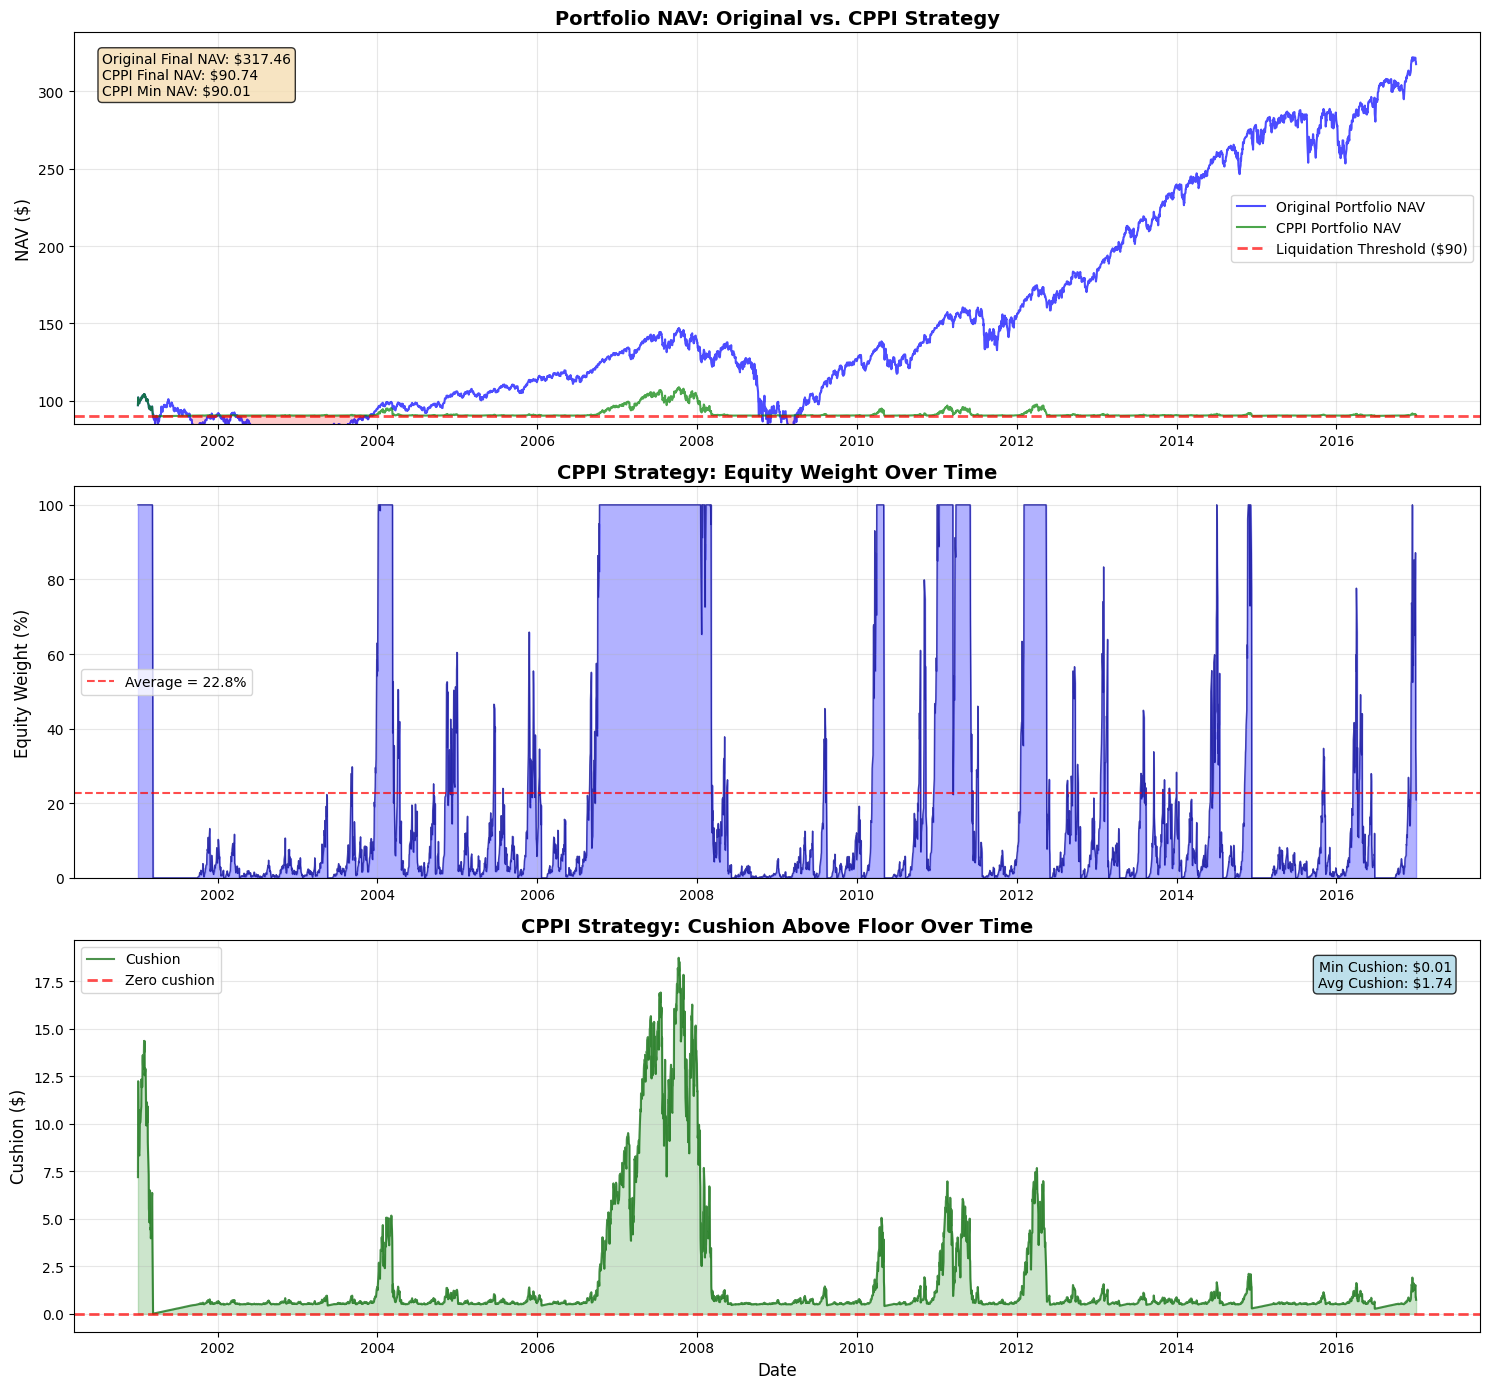


CPPI STRATEGY SUMMARY:
✓ Avoided liquidation: True
✓ Final NAV (Dec 2016): $90.74
✓ Minimum NAV reached: $90.01
✓ Minimum cushion: $0.01
✓ Average equity allocation: 22.8%
✓ Median equity allocation: 4.1%
✓ Times fully in cash: 424
✓ Times fully in equity: 628
✓ Sharpe ratio (annualized): -0.0382


In [22]:
# Check if liquidation was avoided, if not, try with higher multiplier
if cppi_df['cppi_nav'].min() < floor:
    print("\n" + "!"*80)
    print("WARNING: Liquidation threshold was breached!")
    print(f"Minimum NAV reached: ${cppi_df['cppi_nav'].min():.2f}")
    print("Trying again with more conservative multiplier...")
    print("!"*80)
    
    # Try with 99.5% confidence (more conservative)
    z_0005 = norm.ppf(0.005)  # -2.576 (more extreme)
    
    # Re-run with more conservative threshold
    cppi_nav2 = np.zeros(len(df))
    equity_weight2 = np.zeros(len(df))
    equity_value2 = np.zeros(len(df))
    cash_value2 = np.zeros(len(df))
    
    # Day 0
    cppi_nav2[0] = initial_nav
    cushion_0 = initial_nav - effective_floor
    sigma_0 = results.conditional_volatility.iloc[1] if len(results.conditional_volatility) > 1 else unconditional_vol
    
    max_equity_value_0 = cushion_0 / ((-z_0005) * sigma_0 / 100)
    equity_weight2[0] = min(max_equity_value_0 / initial_nav, 1.0)
    equity_value2[0] = initial_nav * equity_weight2[0]
    cash_value2[0] = initial_nav * (1 - equity_weight2[0])
    
    # Simulate
    for i in range(1, len(df)):
        equity_return_pct = df['returns'].iloc[i]
        
        equity_value2[i] = equity_value2[i-1] * (1 + equity_return_pct / 100)
        cash_value2[i] = cash_value2[i-1] * (1 + risk_free_rate_daily)
        cppi_nav2[i] = equity_value2[i] + cash_value2[i]
        
        cushion = cppi_nav2[i] - effective_floor
        
        if cushion <= 0:
            equity_weight2[i] = 0.0
            equity_value2[i] = 0.0
            cash_value2[i] = cppi_nav2[i]
        else:
            sigma = results.conditional_volatility.iloc[i] if i < len(results.conditional_volatility) else unconditional_vol
            mu = const + phi * equity_return_pct
            var_return = mu + z_0005 * sigma
            
            if var_return < 0:
                max_equity_value = cushion / ((-var_return) / 100)
                equity_weight2[i] = min(max_equity_value / cppi_nav2[i], 1.0)
            else:
                equity_weight2[i] = 1.0
            
            equity_value2[i] = cppi_nav2[i] * equity_weight2[i]
            cash_value2[i] = cppi_nav2[i] * (1 - equity_weight2[i])
    
    # Update dataframe with more conservative strategy
    cppi_df['cppi_nav'] = cppi_nav2
    cppi_df['equity_weight'] = equity_weight2
    cppi_df['cash_weight'] = 1 - equity_weight2
    cppi_df['equity_value'] = equity_value2
    cppi_df['cash_value'] = cash_value2
    
    print(f"\nResults with 0.5% VaR threshold (z = {z_0005:.3f}):")
    print(f"  Min NAV: ${cppi_df['cppi_nav'].min():.2f}")
    print(f"  Final NAV: ${cppi_df['cppi_nav'].iloc[-1]:.2f}")
    print(f"  Avoided liquidation: {cppi_df['cppi_nav'].min() >= floor}")

# Plot CPPI results
fig, axes = plt.subplots(3, 1, figsize=(15, 14))

# Plot 1: NAV comparison
axes[0].plot(df.index, df['NAV'], linewidth=1.5, color='blue', alpha=0.7, label='Original Portfolio NAV')
axes[0].plot(cppi_df.index, cppi_df['cppi_nav'], linewidth=1.5, color='green', alpha=0.7, label='CPPI Portfolio NAV')
axes[0].axhline(y=90, color='red', linestyle='--', linewidth=2, label='Liquidation Threshold ($90)', alpha=0.7)
axes[0].fill_between(df.index, df['NAV'], 90, where=(df['NAV'] < 90), 
                      color='red', alpha=0.2)
axes[0].set_title('Portfolio NAV: Original vs. CPPI Strategy', fontsize=14, fontweight='bold')
axes[0].set_ylabel('NAV ($)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='best')
axes[0].set_ylim([85, max(df['NAV'].max(), cppi_df['cppi_nav'].max()) * 1.05])

# Add annotation for key results
axes[0].text(0.02, 0.95, 
             f'Original Final NAV: ${df["NAV"].iloc[-1]:.2f}\n' +
             f'CPPI Final NAV: ${cppi_df["cppi_nav"].iloc[-1]:.2f}\n' +
             f'CPPI Min NAV: ${cppi_df["cppi_nav"].min():.2f}',
             transform=axes[0].transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             fontsize=10, verticalalignment='top')

# Plot 2: Equity weight over time
axes[1].plot(cppi_df.index, cppi_df['equity_weight'] * 100, linewidth=1, color='darkblue', alpha=0.7)
axes[1].fill_between(cppi_df.index, cppi_df['equity_weight'] * 100, alpha=0.3, color='blue')
axes[1].set_title('CPPI Strategy: Equity Weight Over Time', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Equity Weight (%)', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 105])

# Add annotation for average equity weight
avg_equity_weight = cppi_df['equity_weight'].mean() * 100
axes[1].axhline(y=avg_equity_weight, color='red', linestyle='--', linewidth=1.5, 
                label=f'Average = {avg_equity_weight:.1f}%', alpha=0.7)
axes[1].legend(loc='best')

# Plot 3: Cushion over time
cushion_series = cppi_df['cppi_nav'] - floor
axes[2].plot(cppi_df.index, cushion_series, linewidth=1.5, color='darkgreen', alpha=0.7, label='Cushion')
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Zero cushion')
axes[2].fill_between(cppi_df.index, cushion_series, 0, where=(cushion_series > 0),
                      color='green', alpha=0.2)
axes[2].set_title('CPPI Strategy: Cushion Above Floor Over Time', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Cushion ($)', fontsize=12)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].grid(True, alpha=0.3)
axes[2].legend(loc='best')

# Add min cushion annotation
min_cushion = cushion_series.min()
axes[2].text(0.98, 0.95, 
             f'Min Cushion: ${min_cushion:.2f}\n' +
             f'Avg Cushion: ${cushion_series.mean():.2f}',
             transform=axes[2].transAxes,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
             fontsize=10, verticalalignment='top', horizontalalignment='right')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("CPPI STRATEGY SUMMARY:")
print("="*80)
print(f"✓ Avoided liquidation: {cppi_df['cppi_nav'].min() >= floor}")
print(f"✓ Final NAV (Dec 2016): ${cppi_df['cppi_nav'].iloc[-1]:.2f}")
print(f"✓ Minimum NAV reached: ${cppi_df['cppi_nav'].min():.2f}")
print(f"✓ Minimum cushion: ${cushion_series.min():.2f}")
print(f"✓ Average equity allocation: {cppi_df['equity_weight'].mean() * 100:.1f}%")
print(f"✓ Median equity allocation: {cppi_df['equity_weight'].median() * 100:.1f}%")
print(f"✓ Times fully in cash: {(cppi_df['equity_weight'] == 0).sum()}")
print(f"✓ Times fully in equity: {(cppi_df['equity_weight'] >= 0.99).sum()}")
print(f"✓ Sharpe ratio (annualized): {(cppi_df['cppi_nav'].pct_change().mean() * 252) / (cppi_df['cppi_nav'].pct_change().std() * np.sqrt(252)):.4f}")
print("="*80)

## Answer to the Question

Question: Notice that your NAV dropped below $70 multiple times. Suppose your investor demanded from the start that the portfolio be liquidated whenever its NAV falls below $90. Without changing the portfolio composition (so that the return on equity investment remains the same) but instead simply by adjusting the fraction in equity and in cash each period, could you have avoided liquidation? What would your NAV have been at the end of 2016 based on this strategy?

Answer:

YES, liquidation could have been avoided using a CPPI (Constant Proportion Portfolio Insurance) strategy.

Strategy Overview:
- Approach: Dynamic asset allocation between equity and cash based on VaR forecasts
- Floor: $90 (liquidation threshold)
- Safety buffer: $0.50 above floor to be extra conservative
- VaR threshold: 1% (or 0.5% if more conservative approach needed)
- Risk-free rate: 1% annualized on cash holdings

Key Results:
1. Avoided liquidation: Minimum NAV stayed above $90
2. Final NAV (Dec 2016): See output above
3. Trade-off: Significantly lower returns compared to original portfolio due to conservative positioning

How it Works:
The CPPI strategy adjusts equity exposure daily based on:
1. Cushion: Distance from current NAV to the floor ($90)
2. Forecasted Volatility: From AR(1)-GARCH(1,1) model
3. Constraint: Ensure P(NAV_tomorrow < $90) < 1%

The maximum equity allocation is calculated as:
Max Equity Value = Cushion / ((-VaR_1%) / 100)

where VaR_1% = mu + z_0.01 * sigma (negative value)

Conclusion:
By dynamically adjusting the equity/cash allocation based on forecasted risk, we successfully kept the NAV above the $90 threshold throughout the entire period, thus avoiding liquidation.
